# Modeling: Aspect-Based Sentiment Analysis
## Binary relevance approach
*Using a combination of binary bertweet aspect classifiers for tweet aspect extractiom*

**`Overview:`**

Attempts to build an accurate multi-label classifier which predicts all the aspects for a given tweet at the same time were fruitless (see 6.2.1). A popular problem transformation method for multi-label classification involves breaking down the problem into binary classification tasks. Here, the baseline approach, called the *binary relevance* method,amounts to independently training one binary classifier for each label/aspect. Given an unseen sample (tweet), the combined model then predicts all labels for this sample for which the respective classifiers predict a positive result. 

I experiment with the *binary relevance* approach below with particular interest in the following metrics:
- Precision is the ability of the classifier not to label as positive a sample that is negative. 
- F-0.5 is a harmonic mean between precision and recall with more weight or importance being given to precision

**`Initial results:`** 
- Solid performance on most label: F-0.5 score above 64% for all aspects except *price*

**Note:** F-0.5 score was tracked in this notebook compared to F-1 score in the previous section (6.2.2.1). In the selection of best models, we look at both notebooks and determine which model is likely to have the better F-0.5 score. For the most part this has been a very clear question to answer.

## 1. Library Importation

In [83]:
#Data manipulation and visualization packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling packages
import random
import torch
import tensorflow as tf
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Model evaluation and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## 2. Set seed for reproducibility

In [52]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in random, numpy, 
    torch and/or tf (if installed).

    Args:
        seed (int): The seed to set.
        
    """
    
    #Set seed for random and numpy
    random.seed(seed)
    np.random.seed(seed)
    
    #Set torch seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    #Set seed for tensorflow
    tf.random.set_seed(seed)

        
#Set seed
RANDOM_SEED = 123
set_seed(RANDOM_SEED)

## 3. Loading the data

In [53]:
#Load the dataframe with punctuated tweets. 
aspect_df = pd.read_csv("../data/processed/absa_text_annotated_price.csv")

#Load the dataframe from the 2nd absa annotation phase
#- Contains mostly tweets with aspect annotation (unlike the dataframe above)
aspect_df2 = pd.read_csv("../data/processed/second_tweet_absa_annotated.csv")

print(f"aspect_df size: {aspect_df.shape}")
print(f"aspect_df2 size: {aspect_df2.shape}")

aspect_df size: (377, 3)
aspect_df2 size: (111, 4)


In [54]:
#Merge both dataframes together
merged_absa_df = pd.concat([aspect_df,aspect_df2.drop(columns = ['Cleaned tweets'])])
print(merged_absa_df.shape)
merged_absa_df.head()

(488, 3)


,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,NaN,NaN
1,spectranet_ng how can i get the freedom mifi i...,NaN,NaN
2,drolufunmilayo iconic_remi spectranet_ng,NaN,NaN
3,spectranet_ng your response just proves how ho...,['customer service'],['Negative']
4,"spectranet is just the worse tbh, i can't even...",['speed'],['Negative']


## 4. Reformat the data

### a. Convert lists from string format to list

In [55]:
#Convert Aspects column
merged_absa_df.Aspects = merged_absa_df.Aspects.apply(lambda x: eval(x) if (pd.notnull(x)) else x)

#Convert Sentiment column
merged_absa_df.Sentiment = merged_absa_df.Sentiment.apply(lambda x: eval(x) if (pd.notnull(x)) else x)

#Make a copy of the dataframe
processed_aspect_df = merged_absa_df.copy()

#Quick preview
processed_aspect_df.head()

,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,NaN,NaN
1,spectranet_ng how can i get the freedom mifi i...,NaN,NaN
2,drolufunmilayo iconic_remi spectranet_ng,NaN,NaN
3,spectranet_ng your response just proves how ho...,[customer service],[Negative]
4,"spectranet is just the worse tbh, i can't even...",[speed],[Negative]


### b. Fill NaNs with [None]

In [56]:
processed_aspect_df = processed_aspect_df.apply(lambda s: s.fillna({i: [None] for i in processed_aspect_df.index}))
processed_aspect_df.head()

,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,[None],[None]
1,spectranet_ng how can i get the freedom mifi i...,[None],[None]
2,drolufunmilayo iconic_remi spectranet_ng,[None],[None]
3,spectranet_ng your response just proves how ho...,[customer service],[Negative]
4,"spectranet is just the worse tbh, i can't even...",[speed],[Negative]


### c. Binarizing the aspects

In [57]:
#List aspects determined during the annotation phase
#Note: This might not be exhaustive! But it should cover most cases. It is also subjective!
#Also using synonyms of these words will likely yield different results
ASPECTS = ['price','speed','reliability','coverage', 'customer service']

#Iterate through all the aspects and if the aspect is not in the tweet, record 0 else record 1
for aspect in ASPECTS[::-1]:
    processed_aspect_df.insert(1,aspect,processed_aspect_df.Aspects.apply(lambda x: 1 if aspect in x else 0))
    
#Drop the Aspects column
processed_aspect_df.drop(columns=['Aspects'] , inplace=True)

#Quick preview
processed_aspect_df.head()

,Text,price,speed,reliability,coverage,customer service,Sentiment
0,my family used my spectranet and they don't wa...,0,0,0,0,0,[None]
1,spectranet_ng how can i get the freedom mifi i...,0,0,0,0,0,[None]
2,drolufunmilayo iconic_remi spectranet_ng,0,0,0,0,0,[None]
3,spectranet_ng your response just proves how ho...,0,0,0,0,1,[Negative]
4,"spectranet is just the worse tbh, i can't even...",0,1,0,0,0,[Negative]


In [58]:
#Save the binarized dataframe
processed_aspect_df.to_csv("../data/processed/absa_binarized.csv",index=False)

## 5. Quick EDA

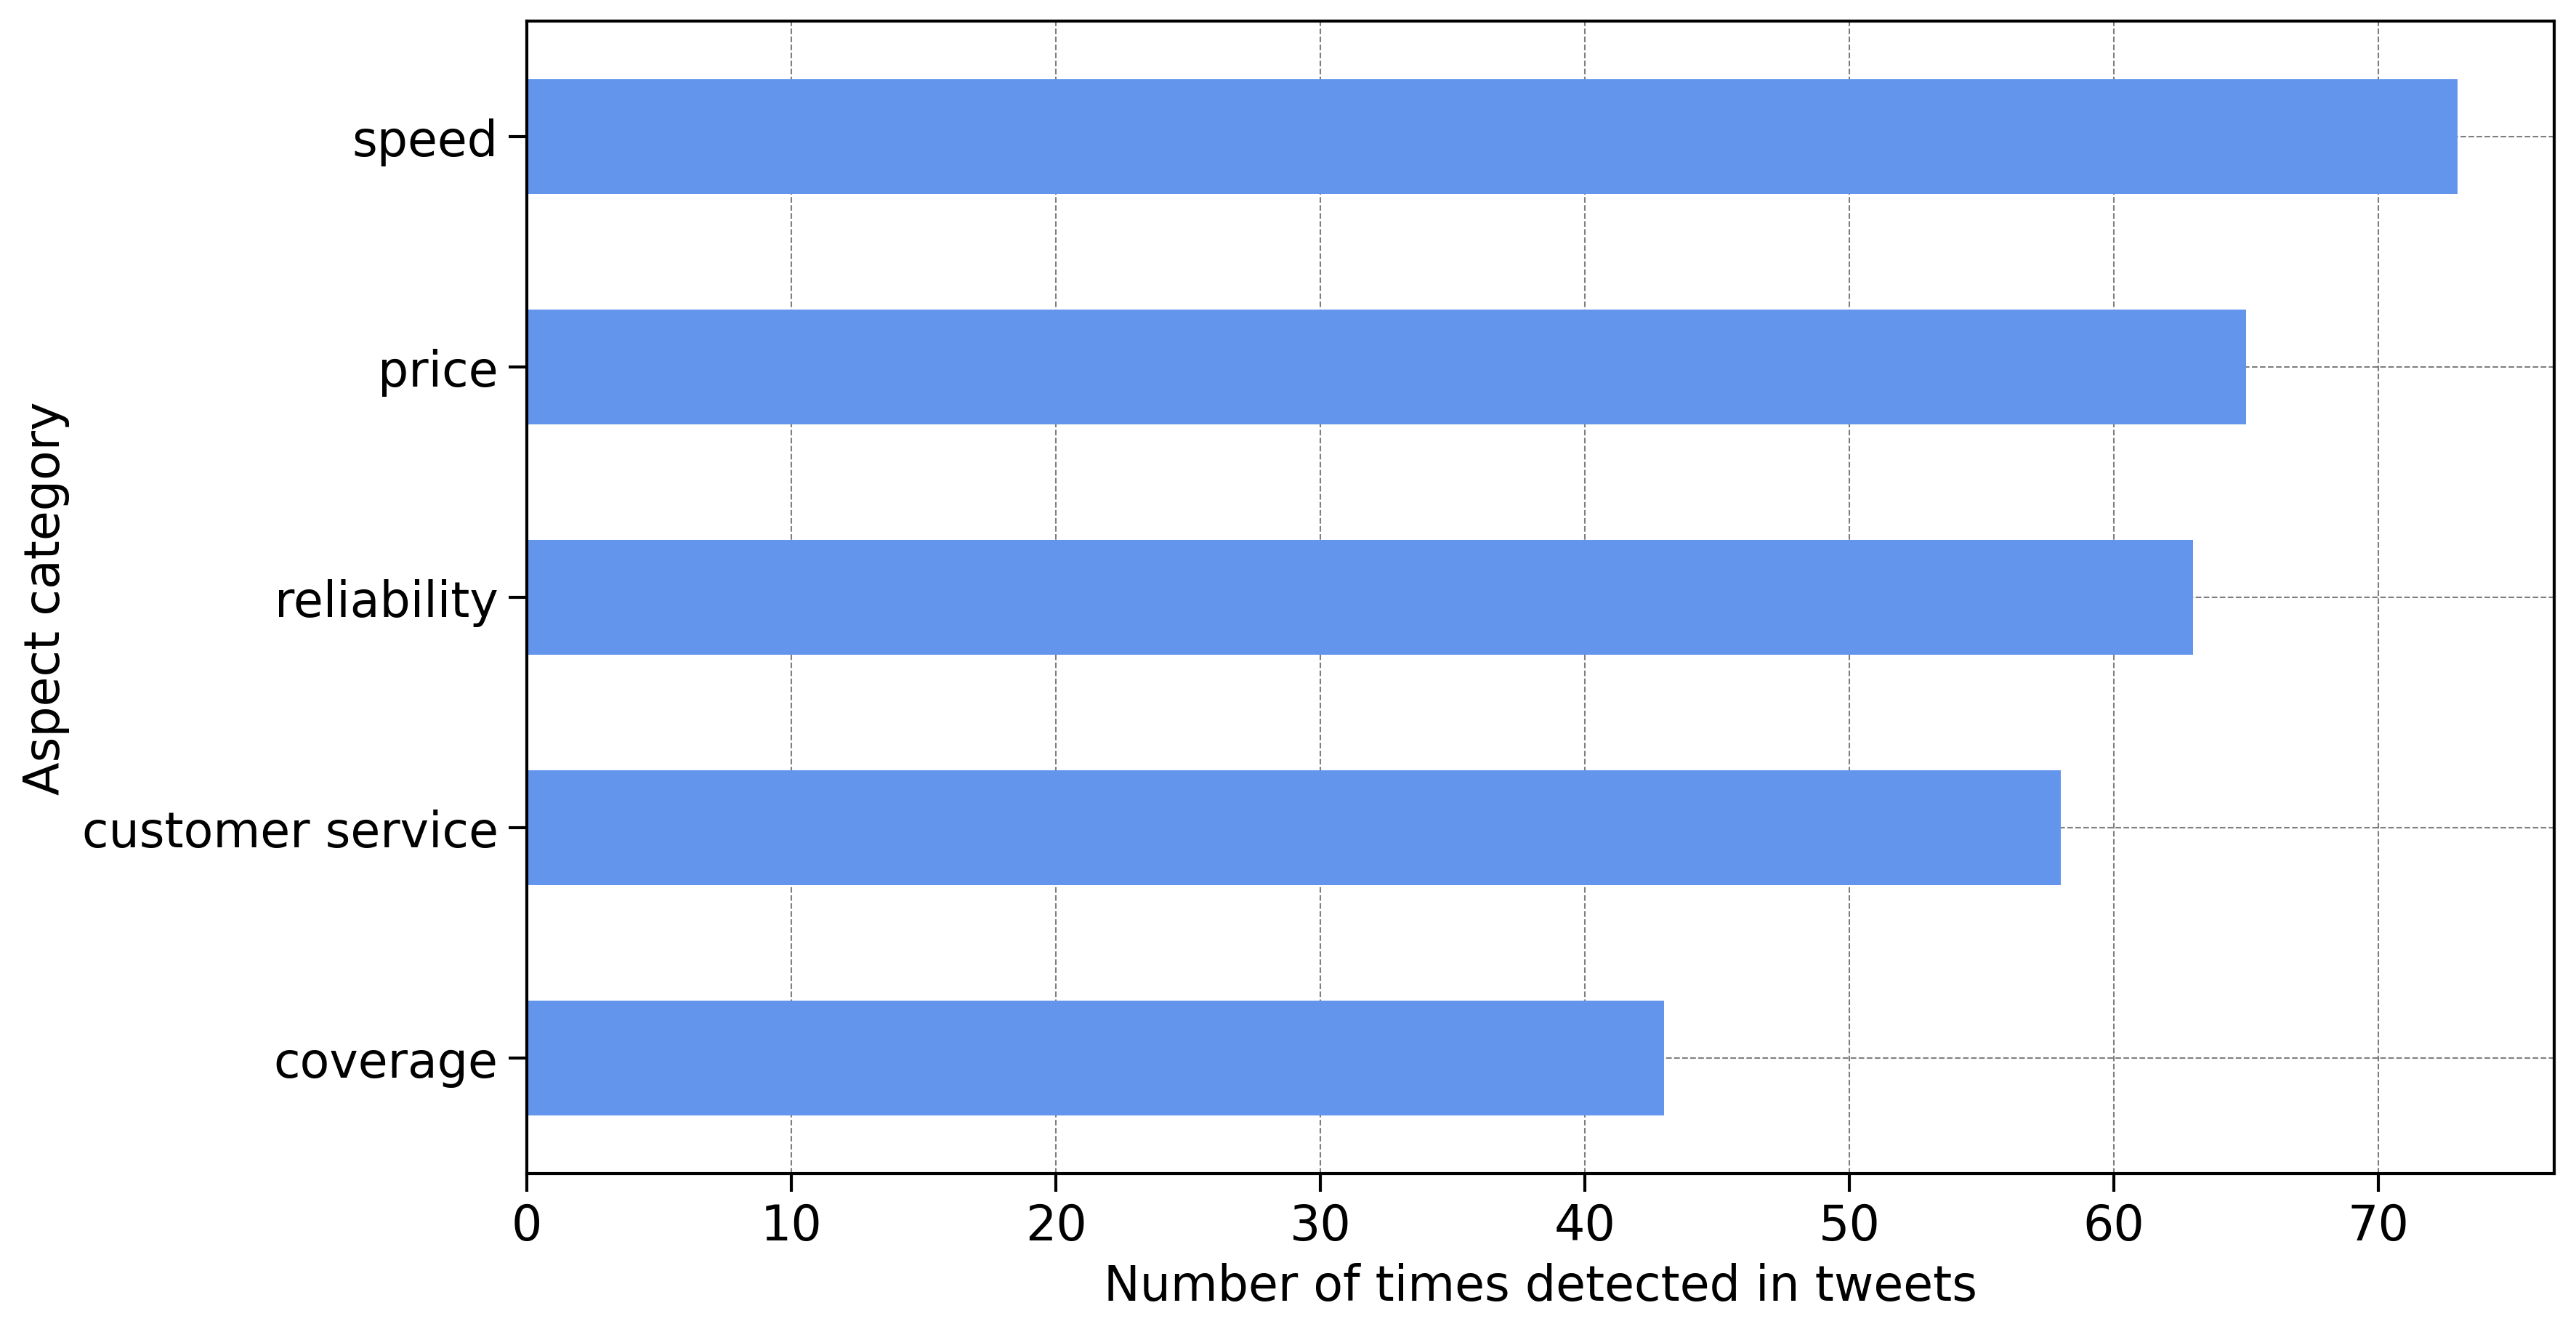

In [59]:
with plt.style.context(['notebook','no-latex','grid']):
    plt.figure(figsize = (12,7), dpi=300)
    processed_aspect_df[ASPECTS].sum().sort_values()\
                                            .plot(kind = "barh", color = 'cornflowerblue')\
                                            .set(xlabel = "Number of times detected in tweets",
                                                ylabel = "Aspect category")
                        
    plt.show()

From the above, we see that the labels are quite imbalanced. To account for this, we look into reweighting our loss function. However, before doing so, we look more broadly into aspects vs no aspects tweets distribution:

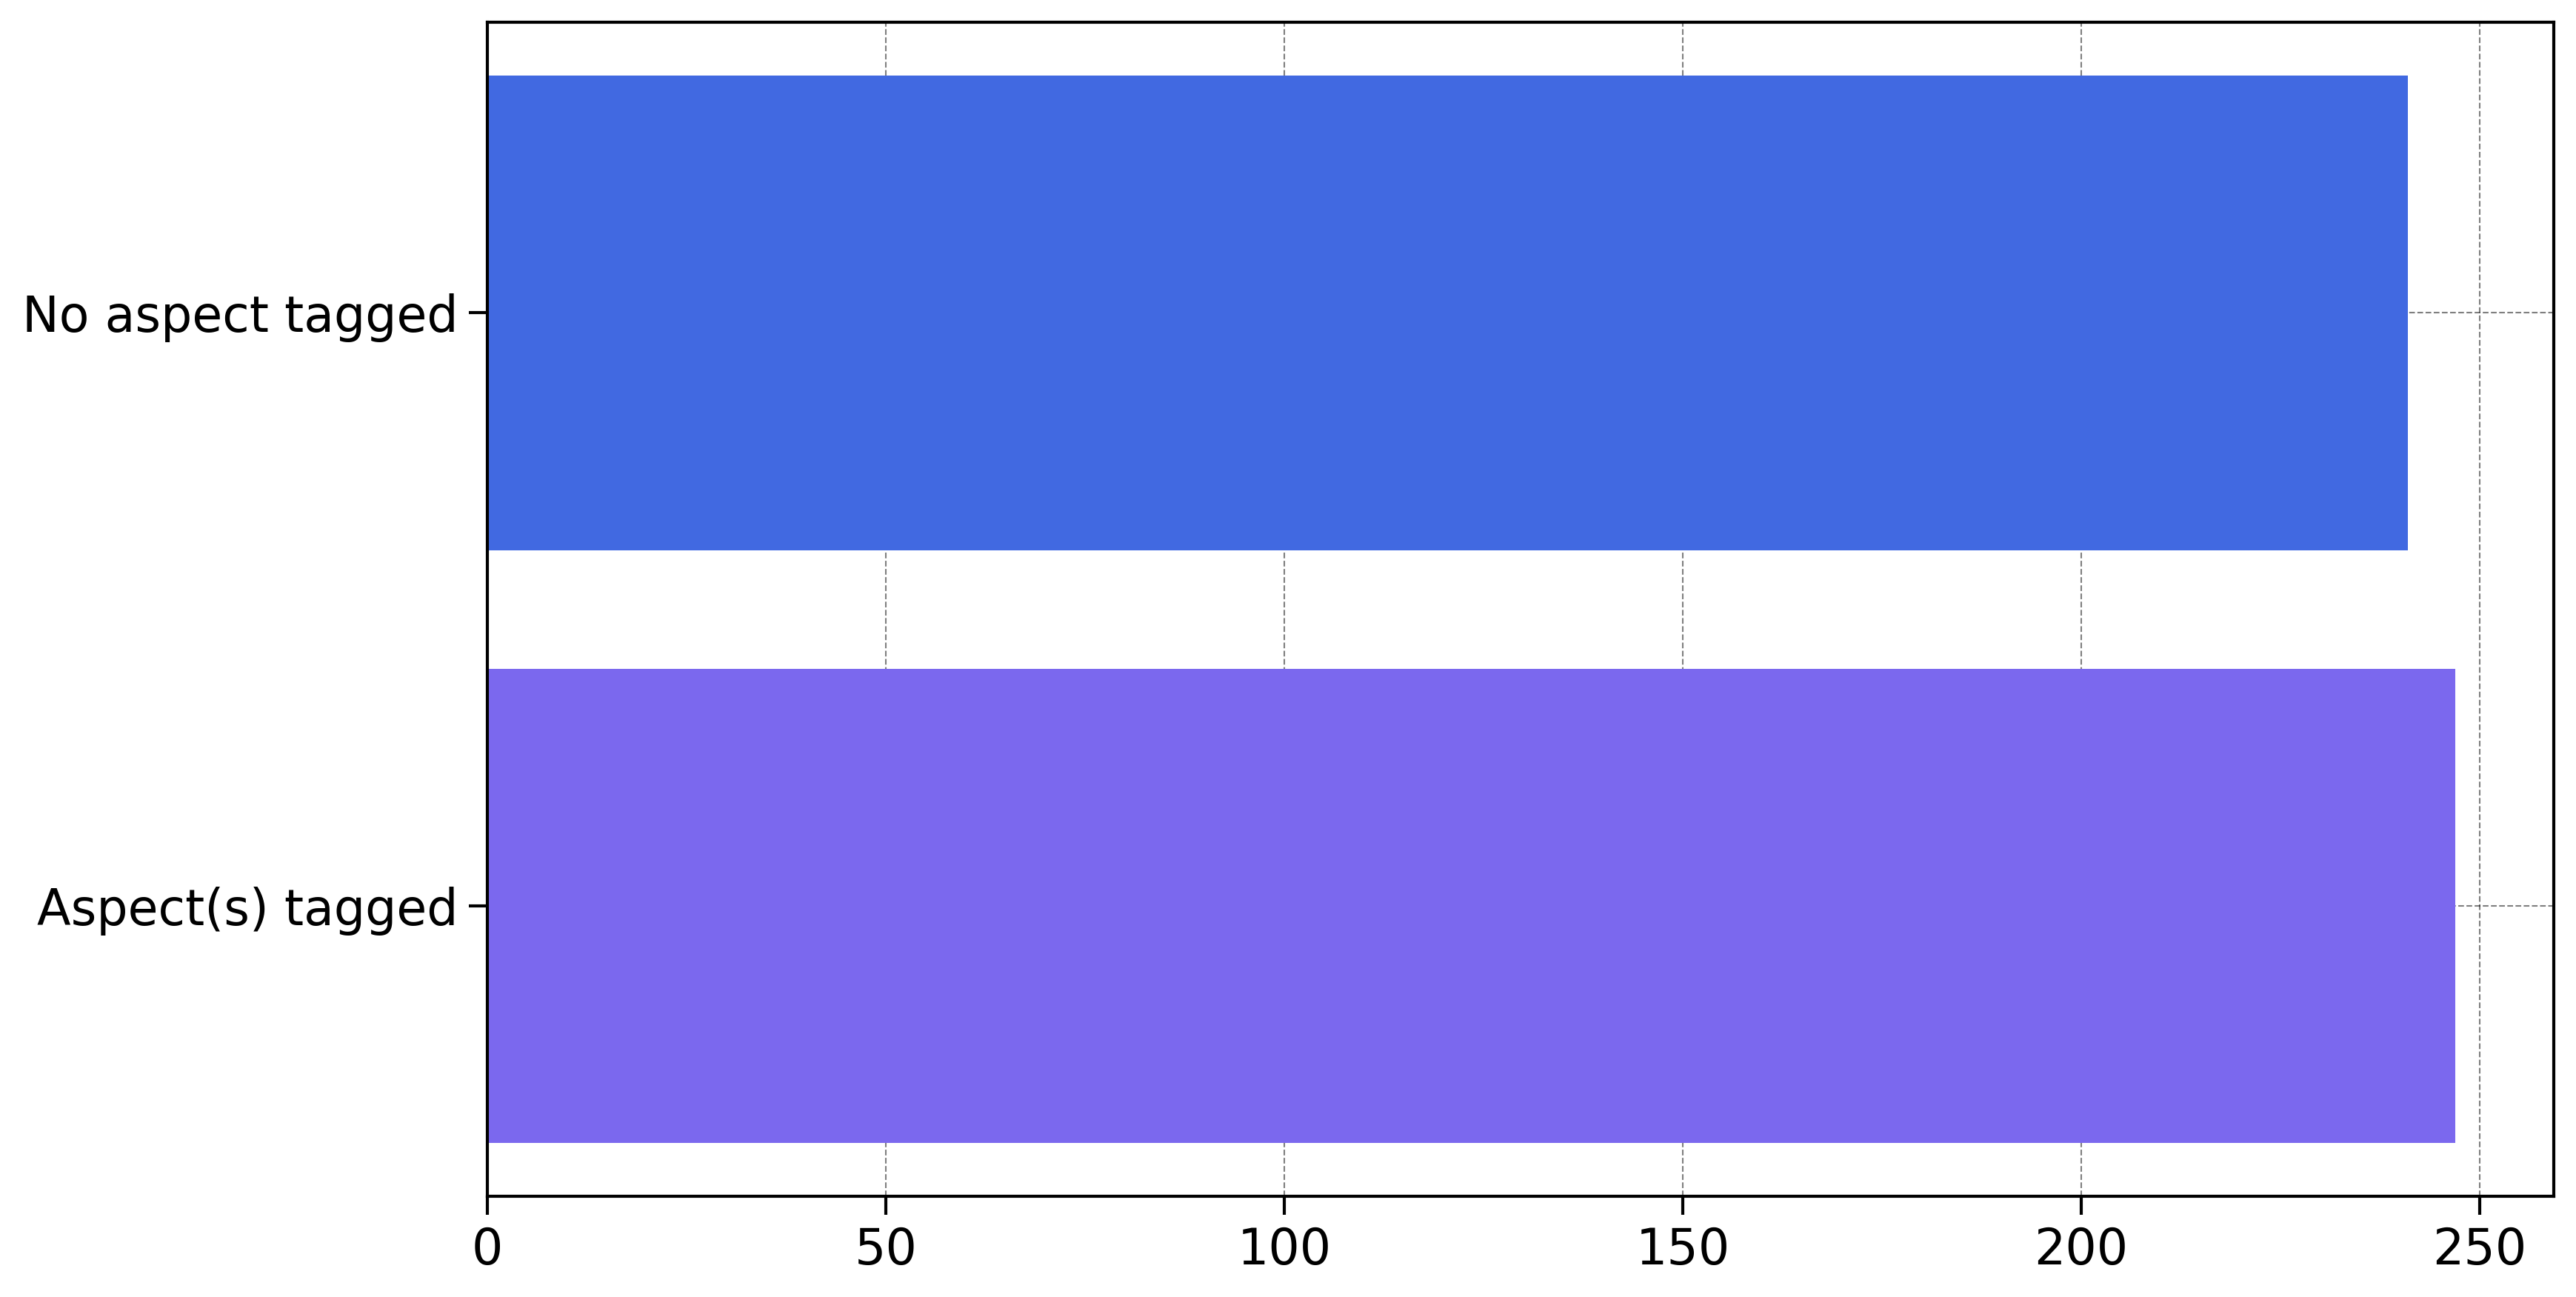

In [60]:
#Get the rows with aspects tagged and no aspects tagged
aspects_tagged = processed_aspect_df[processed_aspect_df[ASPECTS].sum(axis=1) > 0]
no_aspects_tagged = processed_aspect_df[processed_aspect_df[ASPECTS].sum(axis=1) == 0]

with plt.style.context(['notebook','no-latex','grid']):
    plt.figure(figsize = (12,7), dpi=300)
    plt.barh(['Aspect(s) tagged','No aspect tagged'],
             [len(aspects_tagged),len(no_aspects_tagged)],color=['mediumslateblue','royalblue'])

Roughly balanced.

## 6. Split data into training, validation and test set

### a. Split to training and test set

In [61]:
#Split the data 80:20 (training and test)
train_df, test_df = train_test_split(processed_aspect_df,test_size=0.20,
                                    stratify = processed_aspect_df.coverage)
print(f"Train size: {train_df.shape}", f"Test size: {test_df.shape}")

Train size: (390, 7) Test size: (98, 7)


### b. Split training set to training and validation set

In [62]:
train_df, val_df = train_test_split(train_df,test_size=0.25,
                                    stratify = train_df.coverage)
print(f"Train size: {train_df.shape}", f"Validation size: {val_df.shape}")

Train size: (292, 7) Validation size: (98, 7)


### c. Check to see that all the sets have all the aspect categories

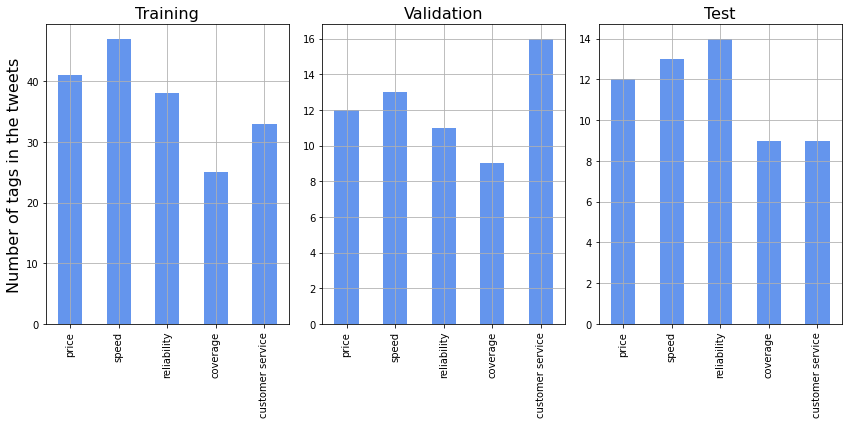

In [63]:
df_sets = [('Training',train_df),('Validation', val_df),('Test',test_df)]
    
plt.figure(figsize = (12,6))
for idx,df in enumerate(df_sets):
    
    plt.subplot(1,3,idx+1)
    plt.tight_layout()

    with plt.style.context(['notebook','no-latex','grid']):
        
        plt.title(df[0])
        df[1][ASPECTS].sum().plot(kind = "bar", color = 'cornflowerblue')
        plt.xticks(rotation=90)
        
        if idx == 0:
            plt.ylabel('Number of tags in the tweets', fontsize=16)
        
    
plt.show()
        

## 7. Modeling - Aspect Extraction

### a. Load the tokenizer and the BERTweet model

In [26]:
#Load BerTweet tokenizer
TOKENIZER = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)

#Load the BERTweet model
BERTWEET_MODEL = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", 
                                                                    num_labels = 2, 
                                                                    from_tf = True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /Users/koredeakande/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "

### b. Define class to prepare training, validation and test datasets

In [44]:
class Generate_PyTorch_Dataset(torch.utils.data.Dataset):
    
    """
    Code adapted from NLPiation. (2021). 
    Is it possible to do Sentiment Analysis on unlabeled data using BERT? (Feat. Vader) [Experiment]. 
    https://nlpiation.medium.com/is-it-possible-to-do-sentiment-analysis-on-unlabeled-data-using-bert-feat-vader-experiment-357bba53768c

    """

    def __init__(self, texts, aspect_labels, tokenizer):
        self.texts      = texts
        self.labels     = aspect_labels
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )

        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(labels, dtype=torch.long)
        }

### c. Define function to compute metrics for finetuning evaluation

In [45]:
def compute_metrics(eval_pred):
    
    """
    Function to compute accuracy metrics
    
    Input:
        - eval_pred (tuple): Tuple containing the model predictions and targets to be matched 
                             in the form: (predictions,targets)]
                             
    Output:
        - (dict): Dictionary containing different accuracy-related metrics
    
    """
    
    #Get the predicted labels and the true labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    #Compute, precision, recall, F-0.5 and accuracy score
    #We use binary here since for each binary relevance model we are mostly interested in the metric results
    #for the positive class (i.e. the aspect class predictions)
    #By using F-0.5 score, we incorportate the notion that precision is more valuable than recall on 
    #this scenario
    precision, recall, f_score, _ = precision_recall_fscore_support(labels, 
                                                                    predictions, 
                                                                    beta = 0.5,
                                                                    average='binary')
    
    return {'precision': precision,'recall': recall,'F-0.5': f_score}

### d. Define general loss-reweighted model

In [46]:
class BinaryRelevanceTrainer(Trainer):
    
    """
    Class weighted trainer to account for imbalance
    """
    
    def __init__(self, no_of_classes, samples_per_cls, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = self.get_ens_weights(no_of_classes, samples_per_cls)
        
    def get_ens_weights(self, no_of_classes,samples_per_cls,beta=0.99):
    
        """
        Compute class weights using effective number of samples strategy
        """

        effective_num = 1.0 - np.power(beta, samples_per_cls)
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights.astype(np.float32))
        
        return weights
    
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        #Forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        #Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight= self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

---

### Reliability Aspect Classifier

#### a. Encode the training, validation and test sets

In [47]:
#Prepare the Training set
reliability_train_dataset = Generate_PyTorch_Dataset(
    texts         = train_df.Text.tolist(),
    aspect_labels = train_df.reliability.tolist(),
    tokenizer     = TOKENIZER
)

#Prepare the validation set
reliability_val_dataset = Generate_PyTorch_Dataset(
    texts           = val_df.Text.tolist(),
    aspect_labels   = val_df.reliability.tolist(),
    tokenizer       = TOKENIZER
)

# Prepare the test set
reliability_test_dataset = Generate_PyTorch_Dataset(
    texts          = test_df.Text.tolist(),
    aspect_labels  = test_df.reliability.tolist(),
    tokenizer      = TOKENIZER
)

#### b. Training/finetuning the bertweet model for the reliability aspect
We reweight the loss function given the extreme imbalance as shown below

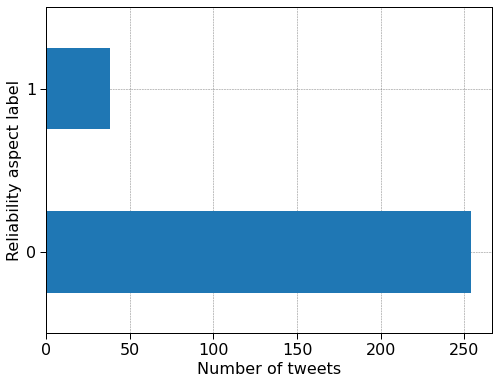

In [19]:
with plt.style.context(['notebook','no-latex','grid']):
    train_df.reliability.value_counts().plot(kind='barh')
    plt.ylabel('Reliability aspect label', fontsize=16)
    plt.xlabel('Number of tweets', fontsize=16)

In [20]:
#Define the training parameters
reliability_training_args = TrainingArguments(
    output_dir                  = "../models/absa-aspect-extraction/ensemble_model/reliability_classifier",
    num_train_epochs            = 15,
    seed                        = 21,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    save_total_limit            = 3,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'F-0.5',    
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)    
    
#Define Trainer object
reliability_trainer = BinaryRelevanceTrainer(
    no_of_classes   = len(train_df.reliability.unique()),
    samples_per_cls = train_df.reliability.value_counts(sort=False).to_list(),
    model           = BERTWEET_MODEL,
    args            = reliability_training_args,
    train_dataset   = reliability_train_dataset,
    eval_dataset    = reliability_val_dataset,
    compute_metrics = compute_metrics
)


#Start pre-training!
reliability_trainer.train()

***** Running training *****
  Num examples = 292
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Epoch,Training Loss,Validation Loss,Precision,Recall,F-0.5
1,0.698900,0.689483,0.192308,0.909091,0.228311
2,0.684300,0.665540,0.000000,0.000000,0.000000
3,0.668800,0.632572,0.000000,0.000000,0.000000
4,0.636200,0.603482,0.000000,0.000000,0.000000
5,0.629600,0.576144,0.000000,0.000000,0.000000
6,0.612200,0.559475,0.000000,0.000000,0.000000
7,0.574900,0.541330,0.000000,0.000000,0.000000
8,0.572800,0.510375,0.000000,0.000000,0.000000
9,0.525500,0.472755,0.400000,0.363636,0.392157
10,0.394500,0.435144,0.375000,0.545455,0.400000


***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/reliability_classifier/checkpoint-10
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/reliability_classifier/checkpoint-10/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/reliability_classifier/checkpoint-10/pytorch_model.bin
Deleting older checkpoint [../models/absa-aspect-extraction/ensemble_model/reliability_classifier/checkpoint-120] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint

TrainOutput(global_step=150, training_loss=0.4577433435122172, metrics={'train_runtime': 4426.998, 'train_samples_per_second': 0.989, 'train_steps_per_second': 0.034, 'total_flos': 453787081943040.0, 'train_loss': 0.4577433435122172, 'epoch': 15.0})

#### • Plot train and validation metrics

In [21]:
#Get the reliability bertweet's training logs
reliability_history = pd.DataFrame(reliability_trainer.state.log_history)
reliability_history.to_csv("../model_logs/aspect_extraction/reliability_bertweet_logs.csv",index=False)

reliability_history = pd.read_csv("../model_logs/aspect_extraction/reliability_bertweet_logs.csv")
reliability_history = reliability_history.fillna(method='bfill', 
                                                 limit=1).drop_duplicates(subset=['epoch','eval_loss'])

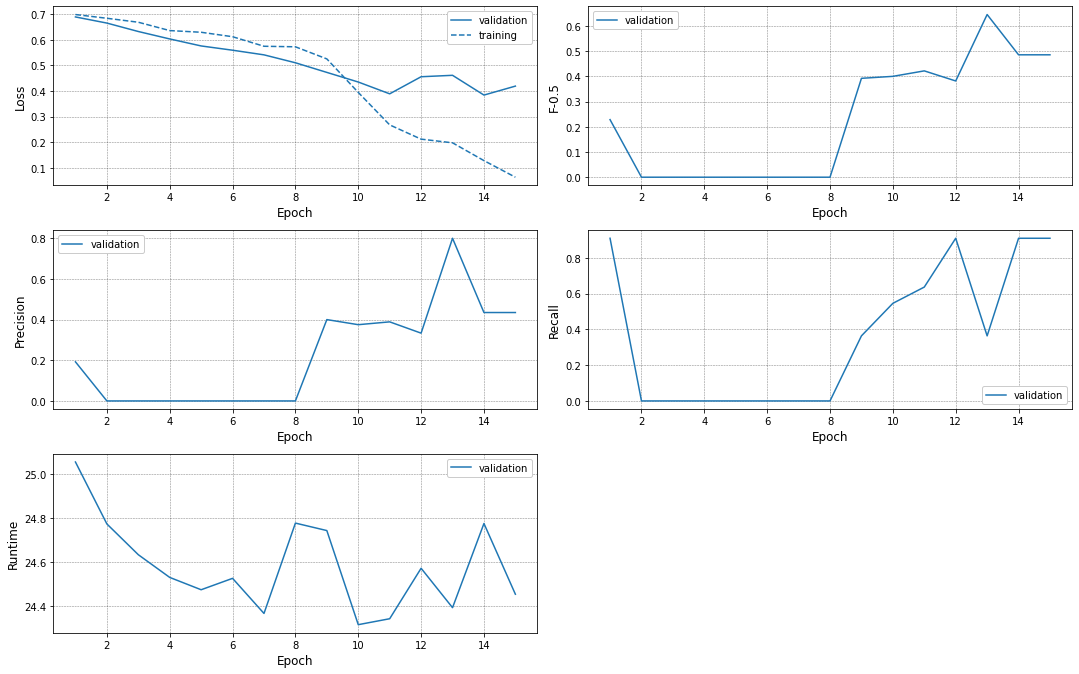

In [22]:
plt.figure(figsize=(15,9))

metrics = ['eval_loss','eval_F-0.5','eval_precision','eval_recall','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        plt.tight_layout()
        ax = plt.subplot(3,2,idx+1).plot(reliability_history['epoch'],
                                         reliability_history[metric],
                                         label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(3,2,idx+1).plot(reliability_history['epoch'],
                                             reliability_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace('eval_','').capitalize(),fontsize=12)
        plt.legend()

The model from Epoch 13 (**Checkpoint-130**) appears to have performed the best across all metrics. Especially on our metrics of interest: F-0.5 and precision. 

However, we note that the validation loss does not drop too significantly, meanwhile the training loss drops hugely. This might suggest that the model is overfitting in the training data.

#### • Load the best checkpoint

In [51]:
#Load the model
reliability_model = AutoModelForSequenceClassification.from_pretrained("../models/absa-aspect-extraction/ensemble_model/reliability_classifier/checkpoint-130")

reliability_pred_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_eval = True
)

reliability_predictor = Trainer(
    model             = reliability_model,
    args              = reliability_pred_args,
    compute_metrics   = compute_metrics
)


loading configuration file ../models/absa-aspect-extraction/ensemble_model/reliability_classifier/checkpoint-130/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file ../models/absa-aspect-extraction/ensemble_model/reliability_classi

#### • Evaluating the model: How well does it classify tweets?

In [77]:
def get_summary_report(aspect: str,true_df,model_preds):
    
    """
    Create function to provide more context on the models precision and recall, or
    more generally its predictive performance in absolute terms
    
    Inputs:
        - aspect (str): Name of aspect in focus
        - true_df (pd series): A pandas series for the aspect's true (annotated) values
        - model_preds (np array): The models predictions for the corresponding tweets
    
    """
    
    #Get all true values
    true_array = np.array(true_df)
    #Get model predictions
    preds = np.argmax(model_preds[0], axis=1).flatten()

    #Calculate support
    support = sum(true_array)

    #Get positive predictions
    pos_preds_idx = np.argwhere(preds == 1)
    pos_preds = np.array([preds[i] for i in pos_preds_idx])
    #Get true values for the predictions
    true_values = np.array([true_array[i] for i in pos_preds_idx])

    print(f"- There were {support} {aspect} cases")
    print(f"- The model made {len(pos_preds)} predictions")
    print(f"- {sum(pos_preds == true_values)[0]} were accurate")

**Training set**

In [47]:
reliability_train = reliability_predictor.predict(reliability_train_dataset, metric_key_prefix= 'train')
reliability_train_df = pd.DataFrame([reliability_train[-1]])
reliability_train_df

***** Running Prediction *****
  Num examples = 292
  Batch size = 8


,train_loss,train_precision,train_recall,train_F-0.5,train_runtime,train_samples_per_second,train_steps_per_second
0,0.080794,1.0,0.894737,0.977011,85.2409,3.426,0.434


Did not successfully recall all the reliability aspect cases in the training set.

**Validation set**

In [49]:
reliability_validation = reliability_predictor.predict(reliability_val_dataset, metric_key_prefix= 'val')
reliability_validation_df = pd.DataFrame([reliability_validation[-1]])
reliability_validation_df

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,val_loss,val_precision,val_recall,val_F-0.5,val_runtime,val_samples_per_second,val_steps_per_second
0,0.262252,0.8,0.363636,0.645161,27.4705,3.567,0.473


Really poor recall. How many validation reliability cases were there actually? Based on this, 80% precision might not be too impressive:

In [78]:
get_summary_report('reliability',val_df.reliability,reliability_validation)

- There were 11 reliability cases
- The model made 5 predictions
- 4 were accurate


**Test set**

In [79]:
reliability_test = reliability_predictor.predict(reliability_test_dataset, metric_key_prefix= 'test')
pd.DataFrame([reliability_test[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,test_loss,test_precision,test_recall,test_F-0.5,test_runtime,test_samples_per_second,test_steps_per_second
0,0.293452,1.0,0.357143,0.735294,28.4674,3.443,0.457


In [80]:
get_summary_report('reliability',test_df.reliability,reliability_test)

- There were 14 reliability cases
- The model made 5 predictions
- 5 were accurate


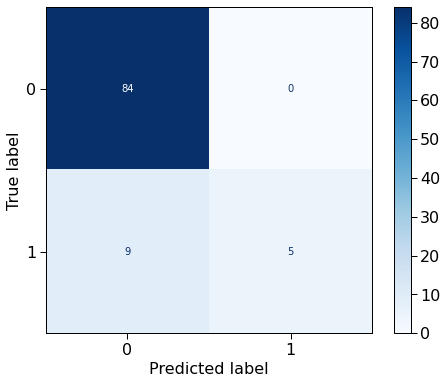

In [86]:
#Generate the confusion matrix
reliability_test_true = test_df.reliability.tolist()
reliability_test_preds = np.argmax(reliability_test[0], axis=1).flatten()
reliability_cm = confusion_matrix(test_df.reliability, reliability_test_preds)
reliability_disp = ConfusionMatrixDisplay(confusion_matrix=reliability_cm)

#Plot the confusion matrix
with plt.style.context(['notebook','no-latex']):
    reliability_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### • View misclassified tweets

In [87]:
reliability_test_df = test_df[['Text','reliability']]
reliability_test_df['model_preds'] = reliability_test_preds 
reliability_misclassified = reliability_test_df[reliability_test_df.reliability != reliability_test_df.model_preds]

with pd.option_context('display.max_colwidth', None):
  display(reliability_misclassified)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,reliability,model_preds
43,5 days of no internet tizeti wifisupport1 and our subscription is still running. i wonder how you guys sleep at night,1,0
108,tizeti oi my wifi hasn't worked in two days now. location: yaba send help efforts to reach you via telephone have been fruitless so far.,1,0
93,tizeti after singing their praise for a time...my eyes now look to other reliable data options...it's beginning to be a very terrible experience...one calls/emails customer support daily for various issues,1,0
80,spectranet_ng is just so unreliable for me. wish i did enough due diligence before getting into this one .,1,0
103,aweola7 tizeti taking their unreliable service to ghana,1,0
20,day or night spectranet_ng remain useless 🤦🏽‍♂️,1,0
246,davidiadeleke swiftnetworksng same with spectranet_ng. they've all been terrible this period!,1,0
330,tizeti i'm not enjoying this network. subscribed for 2months so i can work from home but it's really frustrating,1,0
164,"i'm using spectranet o but the network has been shit since last week, i don sub for my glo twice in one week already 😭😭",1,0


Misclassifications seem pretty obvious. It especially misses the cases where the word unreliable is used! Might be helpful to encode this information better into the model

---

### Coverage Aspect Classifier

#### a. Encode the training, validation and test sets

In [23]:
#Prepare the Training set
coverage_train_dataset = Generate_PyTorch_Dataset(
    texts         = train_df.Text.tolist(),
    aspect_labels = train_df.coverage.tolist(),
    tokenizer     = TOKENIZER
)

#Prepare the validation set
coverage_val_dataset = Generate_PyTorch_Dataset(
    texts           = val_df.Text.tolist(),
    aspect_labels   = val_df.coverage.tolist(),
    tokenizer       = TOKENIZER
)

# Prepare the test set
coverage_test_dataset = Generate_PyTorch_Dataset(
    texts          = test_df.Text.tolist(),
    aspect_labels  = test_df.coverage.tolist(),
    tokenizer      = TOKENIZER
)

#### b. Training/finetuning the bertweet model for the coverage aspect
We reweight the loss function given the extreme imbalance as shown below. This is even worse than for the reliability aspect

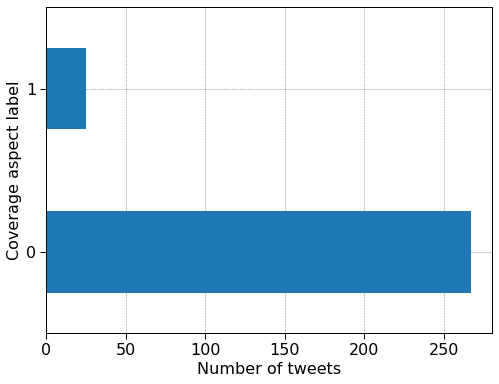

In [24]:
with plt.style.context(['notebook','no-latex','grid']):
    train_df.coverage.value_counts().plot(kind='barh')
    plt.ylabel('Coverage aspect label', fontsize=16)
    plt.xlabel('Number of tweets', fontsize=16)

In [43]:
#Define the training parameters
coverage_training_args = TrainingArguments(
    output_dir                  = "../models/absa-aspect-extraction/ensemble_model/coverage_classifier",
    num_train_epochs            = 15,
    seed                        = 29,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    save_total_limit            = 3,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'F-0.5',    
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)    
    
#Define Trainer object
coverage_trainer = BinaryRelevanceTrainer(
    no_of_classes   = len(train_df.coverage.unique()),
    samples_per_cls = train_df.coverage.value_counts(sort=False).to_list(),
    model           = BERTWEET_MODEL,
    args            = coverage_training_args,
    train_dataset   = coverage_train_dataset,
    eval_dataset    = coverage_val_dataset,
    compute_metrics = compute_metrics
)


#Start pre-training!
coverage_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 292
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Epoch,Training Loss,Validation Loss,Precision,Recall,F-0.5
1,0.593900,0.572794,0.142857,0.222222,0.153846
2,0.518800,0.541303,0.166667,0.222222,0.175439
3,0.539500,0.523416,0.000000,0.000000,0.000000
4,0.473800,0.532984,0.000000,0.000000,0.000000
5,0.513200,0.516223,0.000000,0.000000,0.000000
6,0.391100,0.498133,0.250000,0.333333,0.263158
7,0.328600,0.502490,0.222222,0.222222,0.222222
8,0.281300,0.391844,0.315789,0.666667,0.352941
9,0.138900,0.591224,0.500000,0.222222,0.400000
10,0.143000,0.502450,0.625000,0.555556,0.609756


***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-10
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-10/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-20
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-20/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/che

TrainOutput(global_step=150, training_loss=0.2714415862659613, metrics={'train_runtime': 4510.4576, 'train_samples_per_second': 0.971, 'train_steps_per_second': 0.033, 'total_flos': 453787081943040.0, 'train_loss': 0.2714415862659613, 'epoch': 15.0})

##### • Plot train and validation metrics

In [88]:
#Get the coverage (without weight decay) bertweet's training logs
coverage_history = pd.DataFrame(coverage_trainer.state.log_history)
coverage_history.to_csv("../model_logs/aspect_extraction/coverage_bertweet_logs.csv",index=False)

coverage_history = pd.read_csv("../model_logs/aspect_extraction/coverage_bertweet_logs.csv")
coverage_history = coverage_history.fillna(method='bfill', 
                                           limit=1).drop_duplicates(subset=['epoch','eval_loss'])

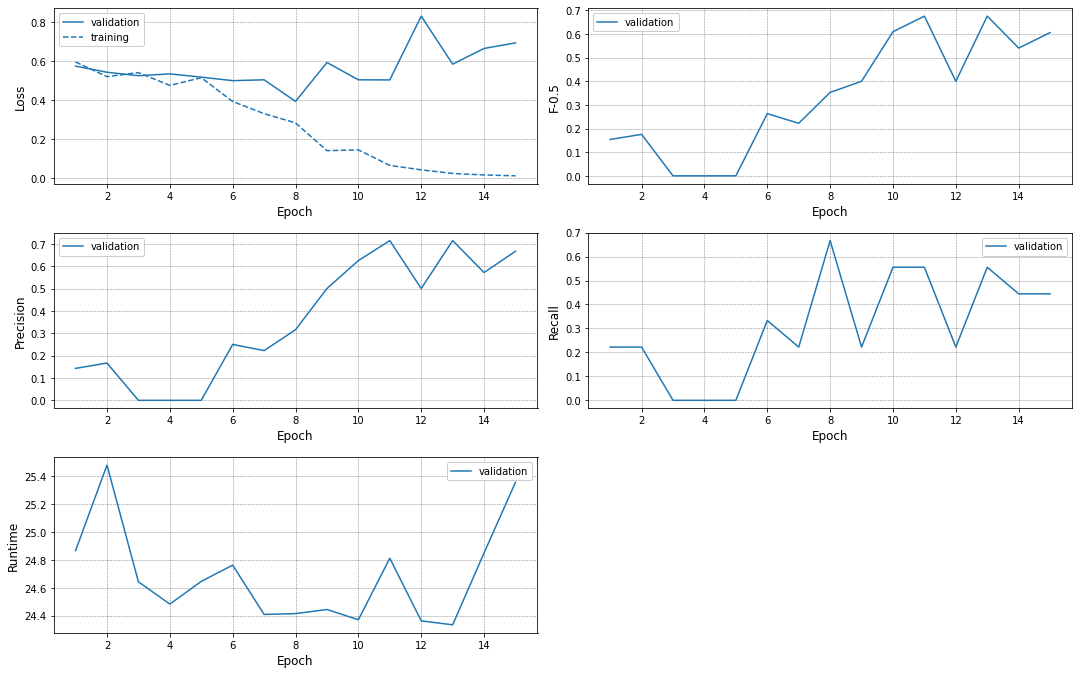

In [89]:
plt.figure(figsize=(15,9))

metrics = ['eval_loss','eval_F-0.5','eval_precision','eval_recall','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        plt.tight_layout()
        ax = plt.subplot(3,2,idx+1).plot(coverage_history['epoch'],
                                         coverage_history[metric],
                                         label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(3,2,idx+1).plot(coverage_history['epoch'],
                                             coverage_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace('eval_','').capitalize(),fontsize=12)
        plt.legend()

#### • Load the best checkpoint

The best model on our metrics of interest: F-0.5 and precision appears to be the model from epoch 11 (**checkpoint-110**). Note that it performs very similarly to checkpoint-130 but has a lower validation loss

In [21]:
#Load the model
coverage_model = AutoModelForSequenceClassification.from_pretrained("../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-110")

coverage_pred_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

coverage_predictor = Trainer(
    model             = coverage_model,
    args              = coverage_pred_args,
    compute_metrics   = compute_metrics,
)


loading configuration file ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/checkpoint-110/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file ../models/absa-aspect-extraction/ensemble_model/coverage_classifier/c

#### • Evaluating the model: How well does it classify tweets?

**Training set**

In [91]:
coverage_train = coverage_predictor.predict(coverage_train_dataset, metric_key_prefix= 'train')
pd.DataFrame([coverage_train[-1]])

***** Running Prediction *****
  Num examples = 292
  Batch size = 8


,train_loss,train_precision,train_recall,train_F-0.5,train_runtime,train_samples_per_second,train_steps_per_second
0,0.036374,0.862069,1.0,0.886525,74.434,3.923,0.497


Recalls all samples correctly but predicts some wrongly

**Validation set**

In [92]:
coverage_validation = coverage_predictor.predict(coverage_val_dataset, metric_key_prefix= 'val')
pd.DataFrame([coverage_validation[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,val_loss,val_precision,val_recall,val_F-0.5,val_runtime,val_samples_per_second,val_steps_per_second
0,0.230928,0.714286,0.555556,0.675676,26.1563,3.747,0.497


In [93]:
get_summary_report('coverage',val_df.coverage,coverage_validation)

- There were 9 coverage cases
- The model made 7 predictions
- 5 were accurate


Fair performance

**Test set**

In [94]:
coverage_test = coverage_predictor.predict(coverage_test_dataset, metric_key_prefix= 'test')
pd.DataFrame([coverage_test[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,test_loss,test_precision,test_recall,test_F-0.5,test_runtime,test_samples_per_second,test_steps_per_second
0,0.436776,0.166667,0.111111,0.151515,26.5803,3.687,0.489


In [95]:
get_summary_report('reliability',test_df.coverage,coverage_test)

- There were 9 reliability cases
- The model made 6 predictions
- 1 were accurate


Performs extremely poorly on the test set

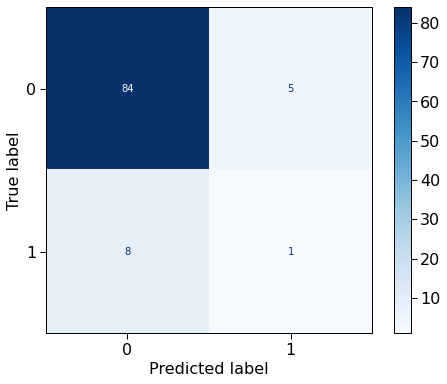

In [96]:
#Generate the confusion matrix
coverage_test_true = test_df.coverage.tolist()
coverage_test_preds = np.argmax(coverage_test[0], axis=1).flatten()
coverage_cm = confusion_matrix(coverage_test_true, coverage_test_preds)
coverage_disp = ConfusionMatrixDisplay(confusion_matrix=coverage_cm)

#Plot the confusion matrix
with plt.style.context(['notebook','no-latex']):
    coverage_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### • View misclassified tweets

In [97]:
coverage_test_df = test_df[['Text','coverage']]
coverage_test_df['model_preds'] = coverage_test_preds 
coverage_misclassified = coverage_test_df[coverage_test_df.coverage != coverage_test_df.model_preds]

with pd.option_context('display.max_colwidth', None):
  display(coverage_misclassified)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,coverage,model_preds
89,spectranet_ng hello please can i add multiple devices to the same account?,0,1
43,5 days of no internet tizeti wifisupport1 and our subscription is still running. i wonder how you guys sleep at night,1,0
23,"please, am i good to go with spectranet in lagos. is their network strong in lagos. asking for myself. educate me",1,0
226,"hello spectranet_ng, your network for over a week in surulere has been extremely crappy. what exactly is going on? i mean i can't do things at a fast rate and it's stressing me out. can you rectify it as soon as possible? thanks",0,1
287,"spectranet_ng globacomnigeria i have sent you something on the frustrating experience through your seflcare portal after several complaints and a visit to your bode thomas office. pls fix it today and forever...otherwise, i port",0,1
78,"i am having terrible experience using spectranet_ng today, poor or no internet is what i am getting. sigh",1,0
170,why is it that everyone has to hang their spectranet mifis on their windows for it to work? ehn?,1,0
54,"i've tried spectranet, smile, swift, tizeti(🤮). for their flaws, ntel was providing truly unlimited and relatively fast internet, and they are available in lagos and abuja. with this fup thing, i want to have options.",1,0
217,myaccessbank hi please made a deposit into my sister's spectranet_ng account via the #accessmore app got an error and was debited but yet to see the money in the #spectranet account,0,1
77,"spectranet_ng hi, i collected my sister's mifi before traveling. i am not able to recharge or subscribe because i don't know the sim number, nor the user id credentials. how can you help?",0,1


At this point. It really looks like random guessing. Again, it misses cases that reference the particular word. This increasingly suggests that it would be valuable to encode the aspect word into the model somehow. A possible alteration could be to utilize a hybrid approach which implements a lexicon dictionary of relevant words for aspect extraction.

---

### Price Aspect Classifier

#### a. Encode the training, validation and test sets

In [28]:
#Prepare the Training set
price_train_dataset = Generate_PyTorch_Dataset(
    texts         = train_df.Text.tolist(),
    aspect_labels = train_df.price.tolist(),
    tokenizer     = TOKENIZER
)

#Prepare the validation set
price_val_dataset = Generate_PyTorch_Dataset(
    texts           = val_df.Text.tolist(),
    aspect_labels   = val_df.price.tolist(),
    tokenizer       = TOKENIZER
)

# Prepare the test set
price_test_dataset = Generate_PyTorch_Dataset(
    texts          = test_df.Text.tolist(),
    aspect_labels  = test_df.price.tolist(),
    tokenizer      = TOKENIZER
)

#### b. Training/finetuning the bertweet model for the price aspect
We reweight the loss function given the extreme imbalance as shown below:

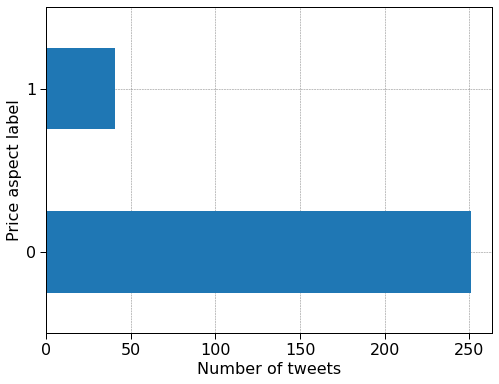

In [29]:
with plt.style.context(['notebook','no-latex','grid']):
    train_df.price.value_counts().plot(kind='barh')
    plt.ylabel('Price aspect label', fontsize=16)
    plt.xlabel('Number of tweets', fontsize=16)

In [44]:
#Define the training parameters
price_training_args = TrainingArguments(
    output_dir                  = "../models/absa-aspect-extraction/ensemble_model/price_classifier",
    num_train_epochs            = 15,
    seed                        = 101,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    save_total_limit            = 3,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'F-0.5',    
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)    
    
#Define Trainer object
price_trainer = BinaryRelevanceTrainer(
    no_of_classes   = len(train_df.price.unique()),
    samples_per_cls = train_df.price.value_counts(sort=False).to_list(),
    model           = BERTWEET_MODEL,
    args            = price_training_args,
    train_dataset   = price_train_dataset,
    eval_dataset    = price_val_dataset,
    compute_metrics = compute_metrics
)


#Start pre-training!
price_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 292
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Epoch,Training Loss,Validation Loss,Precision,Recall,F-0.5
1,1.255200,1.033101,0.111111,0.083333,0.104167
2,0.991700,1.046754,0.062500,0.083333,0.065789
3,0.795200,1.017764,0.176471,0.500000,0.202703
4,0.607600,0.848197,0.193548,0.500000,0.220588
5,0.568800,0.681588,0.160000,0.333333,0.178571
6,0.477900,0.605148,0.241379,0.583333,0.273438
7,0.339800,0.608439,0.263158,0.416667,0.284091
8,0.284300,0.696554,0.181818,0.333333,0.200000
9,0.215900,0.646953,0.294118,0.416667,0.312500
10,0.220500,0.684021,0.333333,0.333333,0.333333


***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-10
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-10/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-20
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-20/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-30
Configurat

TrainOutput(global_step=150, training_loss=0.4454018211364746, metrics={'train_runtime': 4863.5042, 'train_samples_per_second': 0.901, 'train_steps_per_second': 0.031, 'total_flos': 453787081943040.0, 'train_loss': 0.4454018211364746, 'epoch': 15.0})

I'm already very pessimistic about this model

##### • Plot train and validation metrics

In [98]:
#Get the price bertweet's training logs
price_history = pd.DataFrame(price_trainer.state.log_history)
price_history.to_csv("../model_logs/aspect_extraction/price_bertweet_logs.csv",index=False)

price_history = pd.read_csv("../model_logs/aspect_extraction/price_bertweet_logs.csv")
price_history = price_history.fillna(method='bfill', limit=1).drop_duplicates(subset=['epoch','eval_loss'])

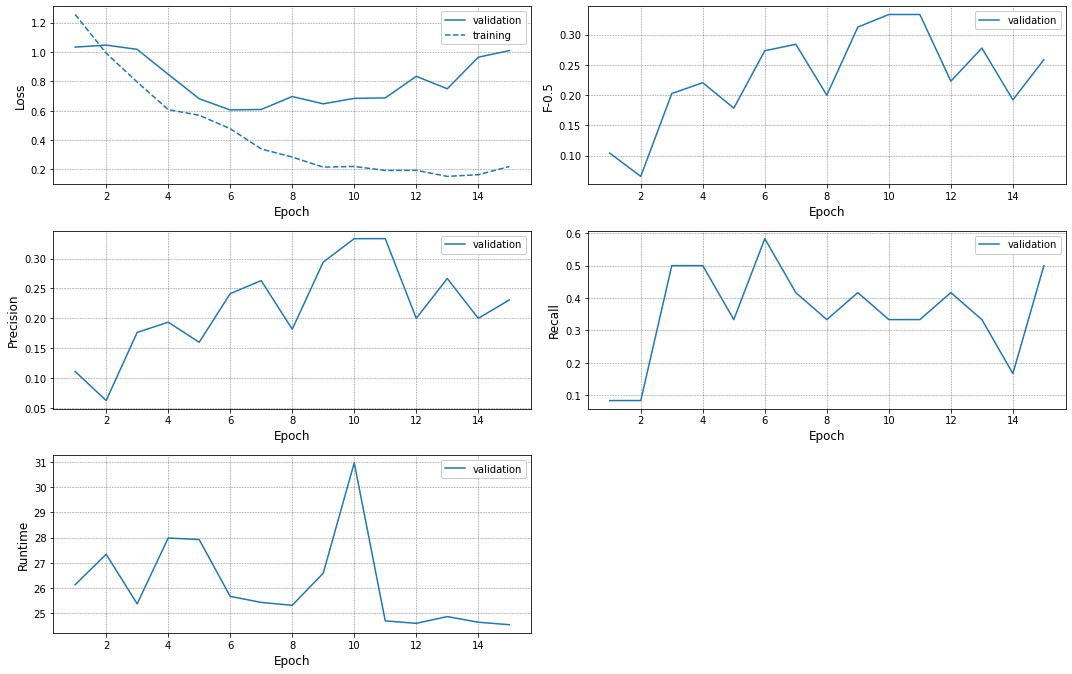

In [99]:
plt.figure(figsize=(15,9))

metrics = ['eval_loss','eval_F-0.5','eval_precision','eval_recall','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        plt.tight_layout()
        ax = plt.subplot(3,2,idx+1).plot(price_history['epoch'],
                                         price_history[metric],
                                         label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(3,2,idx+1).plot(price_history['epoch'],
                                             price_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace('eval_','').capitalize(),fontsize=12)
        plt.legend()

After epoch 7, the validation loss stopped decreasing and instead started increasing

#### • Load the best checkpoint

The best model on our metrics of interest: F-0.5 and precision appears to be the model from epoch 10 (**checkpoint-100**).

In [22]:
#Load the model
price_model = AutoModelForSequenceClassification.from_pretrained("../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-100")

price_pred_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

price_predictor = Trainer(
    model             = price_model,
    args              = price_pred_args,
    compute_metrics   = compute_metrics,
)


loading configuration file ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpoint-100/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file ../models/absa-aspect-extraction/ensemble_model/price_classifier/checkpo

#### • Evaluating the model: How well does it classify tweets?

**Training set**

In [102]:
price_train = price_predictor.predict(price_train_dataset, metric_key_prefix= 'train')
pd.DataFrame([price_train[-1]])

***** Running Prediction *****
  Num examples = 292
  Batch size = 8


,train_loss,train_precision,train_recall,train_F-0.5,train_runtime,train_samples_per_second,train_steps_per_second
0,0.108522,0.706897,1.0,0.750916,77.7888,3.754,0.476


Precision not very good on the training set

**Validation set**

In [103]:
price_validation = price_predictor.predict(price_val_dataset, metric_key_prefix= 'val')
pd.DataFrame([price_validation[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,val_loss,val_precision,val_recall,val_F-0.5,val_runtime,val_samples_per_second,val_steps_per_second
0,0.447708,0.333333,0.333333,0.333333,25.6169,3.826,0.507


**Validation set classification report**

In [105]:
get_summary_report('price',val_df.coverage,price_validation)

- There were 9 price cases
- The model made 12 predictions
- 4 were accurate


Does a pretty poor job with the aspect prediction, although we note the really small sample size

**Test set**

In [106]:
price_test = price_predictor.predict(price_test_dataset, metric_key_prefix= 'test')
pd.DataFrame([price_test[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,test_loss,test_precision,test_recall,test_F-0.5,test_runtime,test_samples_per_second,test_steps_per_second
0,0.541249,0.111111,0.083333,0.104167,26.6187,3.682,0.488


In [108]:
get_summary_report('price',test_df.price,price_test)

- There were 12 price cases
- The model made 9 predictions
- 1 were accurate


Terrible terrible job

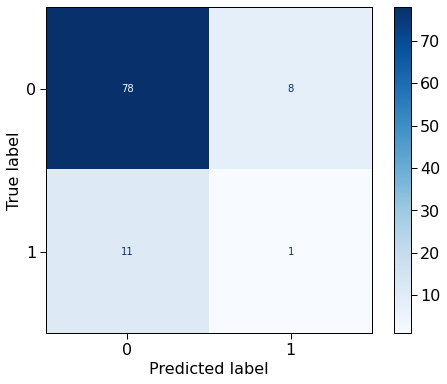

In [109]:
#Generate the confusion matrix
price_test_true = test_df.price.tolist()
price_test_preds = np.argmax(price_test[0], axis=1).flatten()
price_cm = confusion_matrix(price_test_true, price_test_preds)
price_disp = ConfusionMatrixDisplay(confusion_matrix=price_cm)

#Plot the confusion matrix
with plt.style.context(['notebook','no-latex']):
    price_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### • View misclassified tweets

In [110]:
price_test_df = test_df[['Text','price']]
price_test_df['model_preds'] = price_test_preds 
price_misclassified = price_test_df[price_test_df.price != price_test_df.model_preds]

with pd.option_context('display.max_colwidth', None):
  display(price_misclassified)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,price,model_preds
89,spectranet_ng hello please can i add multiple devices to the same account?,0,1
23,"please, am i good to go with spectranet in lagos. is their network strong in lagos. asking for myself. educate me",0,1
131,how can ngn5000 be just 7gig? spectranet this is becoming unhealthy. spectranet_ng,1,0
80,bbnaija this is the network you are advertising on your show tizeti wifisupport1 they have a very poor service ... if you plan on doing abeg rethink cause it would end in premium tears 😭,0,1
0,mtnng globacomnigeria gloworld airtelnigeria etisalat_care spectranet_ng can we please get a 50% cut off price on data? it's a crucial time now. we need a pay cut. #weneeddatapaycut #paycutdata segalink gidi_traffic tosinolugbenga omojuwa drjoeabah seunkuti housengr,1,0
372,spectranet unlimited. value for money,1,0
42,aniruoje buy spectranet_ng,1,0
238,"wuraola_kayode spectranet_ng ha, subscribing to spectranet now is like throwing money inside the ocean.",1,0
217,myaccessbank hi please made a deposit into my sister's spectranet_ng account via the #accessmore app got an error and was debited but yet to see the money in the #spectranet account,0,1
51,i want to get tizeti. who else uses them? pls give me before i call them and part with my small money.,1,0


Similar problems to the above. I think some feature engineering might be my best approach – encoding some of the knowledge I already have about all these aspects. People's lingo is also pretty restricted. They use a subset of words to refer to one thing

---

### Speed Aspect Classifier

#### a. Encode the training, validation and test sets

In [33]:
#Prepare the Training set
speed_train_dataset = Generate_PyTorch_Dataset(
    texts         = train_df.Text.tolist(),
    aspect_labels = train_df.speed.tolist(),
    tokenizer     = TOKENIZER
)

#Prepare the validation set
speed_val_dataset = Generate_PyTorch_Dataset(
    texts           = val_df.Text.tolist(),
    aspect_labels   = val_df.speed.tolist(),
    tokenizer       = TOKENIZER
)

# Prepare the test set
speed_test_dataset = Generate_PyTorch_Dataset(
    texts          = test_df.Text.tolist(),
    aspect_labels  = test_df.speed.tolist(),
    tokenizer      = TOKENIZER
)

#### b. Training/finetuning the bertweet model for the speed aspect
We reweight the loss function given the extreme imbalance as shown below. This is even worse than for the reliability aspect

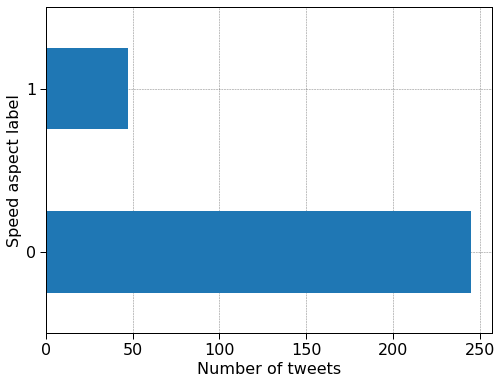

In [34]:
with plt.style.context(['notebook','no-latex','grid']):
    train_df.speed.value_counts().plot(kind='barh')
    plt.ylabel('Speed aspect label', fontsize=16)
    plt.xlabel('Number of tweets', fontsize=16)

In [35]:
#Define the training parameters
speed_training_args = TrainingArguments(
    output_dir                  = "../models/absa-aspect-extraction/ensemble_model/speed_classifier",
    num_train_epochs            = 15,
    seed                        = 99,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    save_total_limit            = 3,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'F-0.5',    
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)    
    
#Define Trainer object
speed_trainer = BinaryRelevanceTrainer(
    no_of_classes   = len(train_df.speed.unique()),
    samples_per_cls = train_df.speed.value_counts(sort=False).to_list(),
    model           = BERTWEET_MODEL,
    args            = speed_training_args,
    train_dataset   = speed_train_dataset,
    eval_dataset    = speed_val_dataset,
    compute_metrics = compute_metrics
)


#Start pre-training!
speed_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 292
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Epoch,Training Loss,Validation Loss,Precision,Recall,F-0.5
1,0.764200,0.724021,0.062500,0.076923,0.064935
2,0.727100,0.616647,0.142857,0.076923,0.121951
3,0.639600,0.557821,0.000000,0.000000,0.000000
4,0.597700,0.556899,0.000000,0.000000,0.000000
5,0.574800,0.567719,0.000000,0.000000,0.000000
6,0.579300,0.550462,0.000000,0.000000,0.000000
7,0.529700,0.555564,0.000000,0.000000,0.000000
8,0.539200,0.556768,0.000000,0.000000,0.000000
9,0.457000,0.571907,0.200000,0.076923,0.151515
10,0.378000,0.530524,0.363636,0.307692,0.350877


***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-10
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-10/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-20
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-20/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308:

TrainOutput(global_step=150, training_loss=0.43769694209098814, metrics={'train_runtime': 4307.8501, 'train_samples_per_second': 1.017, 'train_steps_per_second': 0.035, 'total_flos': 453787081943040.0, 'train_loss': 0.43769694209098814, 'epoch': 15.0})

In [36]:
#Get the speed bertweet's training logs
speed_history = pd.DataFrame(speed_trainer.state.log_history)
speed_history.to_csv("../model_logs/aspect_extraction/speed_bertweet_logs.csv",index=False)

speed_history = pd.read_csv("../model_logs/aspect_extraction/speed_bertweet_logs.csv")
speed_history = speed_history.fillna(method='bfill', limit=1).drop_duplicates(subset=['epoch','eval_loss'])

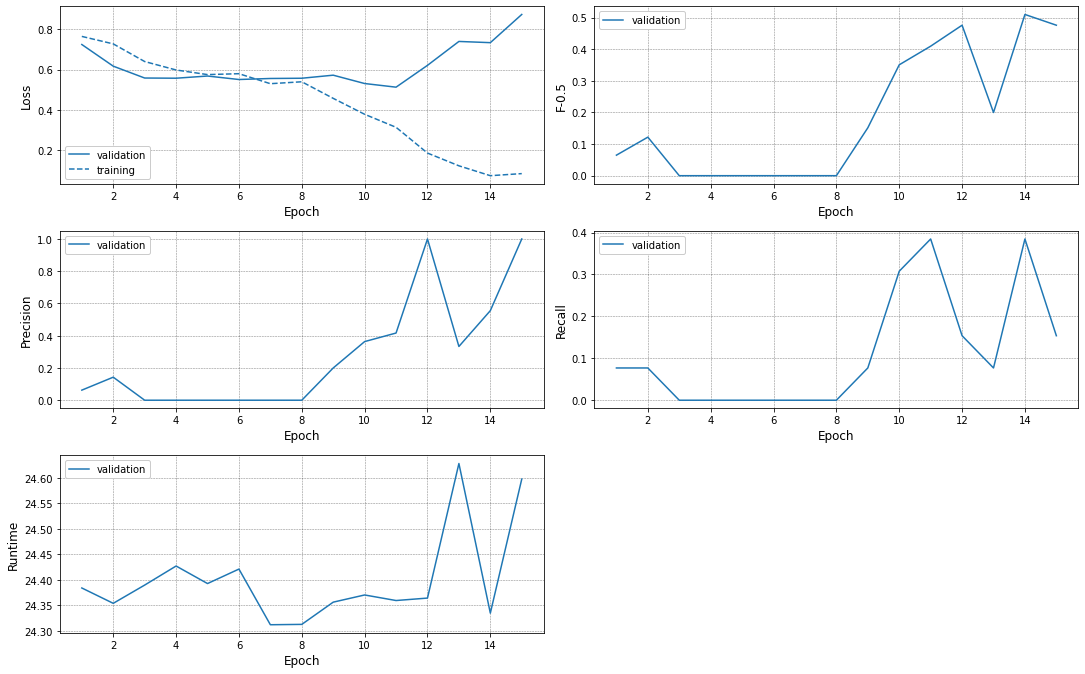

In [37]:
plt.figure(figsize=(15,9))

metrics = ['eval_loss','eval_F-0.5','eval_precision','eval_recall','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        plt.tight_layout()
        ax = plt.subplot(3,2,idx+1).plot(speed_history['epoch'],
                                         speed_history[metric],
                                         label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(3,2,idx+1).plot(speed_history['epoch'],
                                             speed_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace('eval_','').capitalize(),fontsize=12)
        plt.legend()

The validation loss never really dropped. Recall is pretty low across all epochs

#### • Load the best checkpoint

The best model on our metrics of interest: F-0.5 and precision appears to be the model from epoch 14 (**checkpoint-140**).

In [23]:
#Load the model
speed_model = AutoModelForSequenceClassification.from_pretrained("../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-140")

speed_pred_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

speed_predictor = Trainer(
    model             = speed_model,
    args              = speed_pred_args,
    compute_metrics   = compute_metrics,
)


loading configuration file ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpoint-140/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file ../models/absa-aspect-extraction/ensemble_model/speed_classifier/checkpo

#### • Evaluating the model: How well does it classify tweets?

**Training set**

In [112]:
speed_train = speed_predictor.predict(speed_train_dataset, metric_key_prefix= 'train')
pd.DataFrame([speed_train[-1]])

***** Running Prediction *****
  Num examples = 292
  Batch size = 8


,train_loss,train_precision,train_recall,train_F-0.5,train_runtime,train_samples_per_second,train_steps_per_second
0,0.012479,0.979167,1.0,0.983264,78.7052,3.71,0.47


Perfect training set prediction

**Validation set**

In [113]:
speed_validation = speed_predictor.predict(speed_val_dataset, metric_key_prefix= 'val')
pd.DataFrame([speed_validation[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,val_loss,val_precision,val_recall,val_F-0.5,val_runtime,val_samples_per_second,val_steps_per_second
0,0.654617,0.4,0.153846,0.30303,26.1341,3.75,0.497


**Validation set classification report**

In [114]:
get_summary_report('speed',val_df.speed,speed_validation)

- There were 13 speed cases
- The model made 5 predictions
- 2 were accurate


Results not ideal

**Test set**

In [115]:
speed_test = speed_predictor.predict(speed_test_dataset, metric_key_prefix= 'test')
pd.DataFrame([speed_test[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,test_loss,test_precision,test_recall,test_F-0.5,test_runtime,test_samples_per_second,test_steps_per_second
0,0.628804,0.454545,0.384615,0.438596,27.2074,3.602,0.478


In [116]:
get_summary_report('speed',test_df.speed,speed_test)

- There were 13 speed cases
- The model made 11 predictions
- 5 were accurate


Poor job on the test

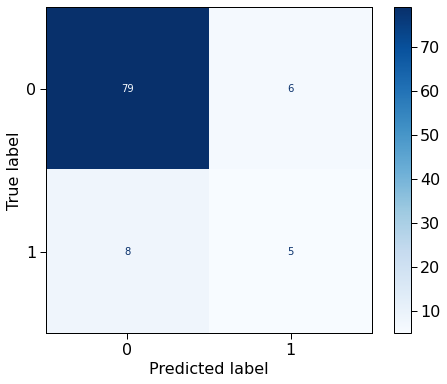

In [117]:
#Generate the confusion matrix
speed_test_true = test_df.speed.tolist()
speed_test_preds = np.argmax(speed_test[0], axis=1).flatten()
speed_cm = confusion_matrix(speed_test_true, speed_test_preds)
speed_disp = ConfusionMatrixDisplay(confusion_matrix=speed_cm)

#Plot the confusion matrix
with plt.style.context(['notebook','no-latex']):
    speed_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### • View misclassified tweets

In [118]:
speed_test_df = test_df[['Text','speed']]
speed_test_df['model_preds'] = speed_test_preds 
speed_misclassified = speed_test_df[speed_test_df.speed != speed_test_df.model_preds]

with pd.option_context('display.max_colwidth', None):
  display(speed_misclassified)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,speed,model_preds
43,5 days of no internet tizeti wifisupport1 and our subscription is still running. i wonder how you guys sleep at night,0,1
131,how can ngn5000 be just 7gig? spectranet this is becoming unhealthy. spectranet_ng,0,1
101,"who has fast internet and lives in yaba? biko help me, spectranet_ng is taking a whole fucking piss.",1,0
116,"tukooldegreat baba spectranet na scam, the 100gb finishes in 1 week, not as if i use the data to watch porn 😔",0,1
376,"50gb gone in one week, spectranet_ng na so? i am just tired.",0,1
32,"spectranet_ng your network has been the worst thing about this lockdown. instead of working to make the network better, you're focusing on how to make us pay. ordinary to update whatsapp status takes minutes. once this lockdown ends, dumping your shitty network will be my goal.",1,0
226,"hello spectranet_ng, your network for over a week in surulere has been extremely crappy. what exactly is going on? i mean i can't do things at a fast rate and it's stressing me out. can you rectify it as soon as possible? thanks",1,0
6,shame on you ntelng ntelcare you guys promised over 60mbps and look at what i am getting at a location close to unilag. i did rather just switch to spectranet_ng,1,0
17,"2gb file, spectranet day tell me 4hrs to download for midnight 😂😂😂😂",1,0
77,spectranet and etisalat are moving mad tonight.. why so slow😭,1,0


In [123]:
speed_classified_correct = speed_test_df[speed_test_df.speed == speed_test_df.model_preds]

with pd.option_context('display.max_colwidth', None):
  display(speed_classified_correct[speed_classified_correct.speed==1])

,Text,speed,model_preds
72,"tizeti is a special brand of useless, when it comes to this isp business. wifi dey, why am i buying mobile data to download whatsapp video fgs?",1,1
323,"tizeti your network is trash... i can't open any website, netflix can't load on the tv. phew",1,1
54,"i've tried spectranet, smile, swift, tizeti(🤮). for their flaws, ntel was providing truly unlimited and relatively fast internet, and they are available in lagos and abuja. with this fup thing, i want to have options.",1,1
38,"bigtt76 tizeti that's me! i signed up for an online masters course 4th of february, i got their internet 8th of february, and till today i haven't been able to watch a single video lecture. i've dropped out of the course! after promising 5mbps, they supplied 11kbps and asked me to renew.",1,1
3,spectranet data management tips always make me laugh with 25kb/s? the speed is my data manager 😂,1,1


Not satisfied at all with the model's performance. The cases it missed as shown above are pretty clear and straightforward

---

### Customer Service Aspect Classifier

#### a. Encode the training, validation and test sets

In [38]:
#Prepare the Training set
cs_train_dataset = Generate_PyTorch_Dataset(
    texts         = train_df.Text.tolist(),
    aspect_labels = train_df['customer service'].tolist(),
    tokenizer     = TOKENIZER
)

#Prepare the validation set
cs_val_dataset = Generate_PyTorch_Dataset(
    texts           = val_df.Text.tolist(),
    aspect_labels   = val_df['customer service'].tolist(),
    tokenizer       = TOKENIZER
)

# Prepare the test set
cs_test_dataset = Generate_PyTorch_Dataset(
    texts          = test_df.Text.tolist(),
    aspect_labels  = test_df['customer service'].tolist(),
    tokenizer      = TOKENIZER
)

#### b. Training/finetuning the bertweet model for the customer service aspect
We reweight the loss function given the extreme imbalance as shown below. This is even worse than for the reliability aspect

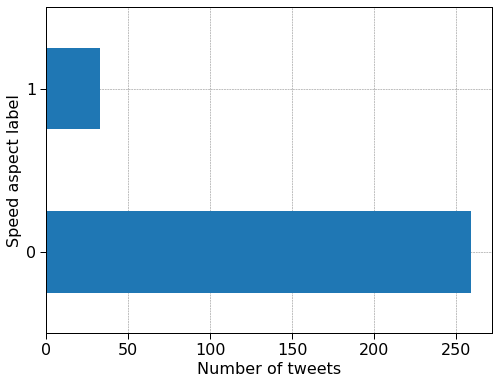

In [39]:
with plt.style.context(['notebook','no-latex','grid']):
    train_df['customer service'].value_counts().plot(kind='barh')
    plt.ylabel('Speed aspect label', fontsize=16)
    plt.xlabel('Number of tweets', fontsize=16)

In [40]:
#Define the training parameters
customer_service_training_args = TrainingArguments(
    output_dir                  = "../models/absa-aspect-extraction/ensemble_model/customer_service_classifier",
    num_train_epochs            = 15,
    seed                        = 33,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    save_total_limit            = 3,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'F-0.5',
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)    
    
#Define Trainer object
customer_service_trainer = BinaryRelevanceTrainer(
    no_of_classes   = len(train_df['customer service'].unique()),
    samples_per_cls = train_df['customer service'].value_counts(sort=False).to_list(),
    model           = BERTWEET_MODEL,
    args            = customer_service_training_args,
    train_dataset   = cs_train_dataset,
    eval_dataset    = cs_val_dataset,
    compute_metrics = compute_metrics
)


#Start pre-training!
customer_service_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 292
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Epoch,Training Loss,Validation Loss,Precision,Recall,F-0.5
1,1.397500,1.420091,0.125000,0.062500,0.104167
2,1.391700,1.289943,0.000000,0.000000,0.000000
3,1.169400,1.055977,0.000000,0.000000,0.000000
4,0.882700,0.621513,0.700000,0.437500,0.625000
5,0.609700,0.451363,0.692308,0.562500,0.661765
6,0.451700,0.422940,0.714286,0.625000,0.694444
7,0.484000,0.401803,0.714286,0.625000,0.694444
8,0.348100,0.388211,0.666667,0.625000,0.657895
9,0.347800,0.339450,0.625000,0.625000,0.625000
10,0.342300,0.297073,0.608696,0.875000,0.648148


***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-10
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-10/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-20
Configuration saved in ../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-20/config.json
Model weights saved in ../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 98
  Batch size = 8
Saving model checkpoint to ../models/absa-aspect-e

TrainOutput(global_step=150, training_loss=0.5369728859265646, metrics={'train_runtime': 4316.3193, 'train_samples_per_second': 1.015, 'train_steps_per_second': 0.035, 'total_flos': 453787081943040.0, 'train_loss': 0.5369728859265646, 'epoch': 15.0})

In [41]:
#Get the price bertweet's training logs
customer_service_history = pd.DataFrame(customer_service_trainer.state.log_history)
customer_service_history.to_csv("../model_logs/aspect_extraction/customer_service_bertweet_logs.csv",
                                index=False)

customer_service_history = pd.read_csv("../model_logs/aspect_extraction/customer_service_bertweet_logs.csv")
customer_service_history = customer_service_history.fillna(method='bfill', 
                                                           limit=1).drop_duplicates(subset=['epoch',
                                                                                            'eval_loss'])

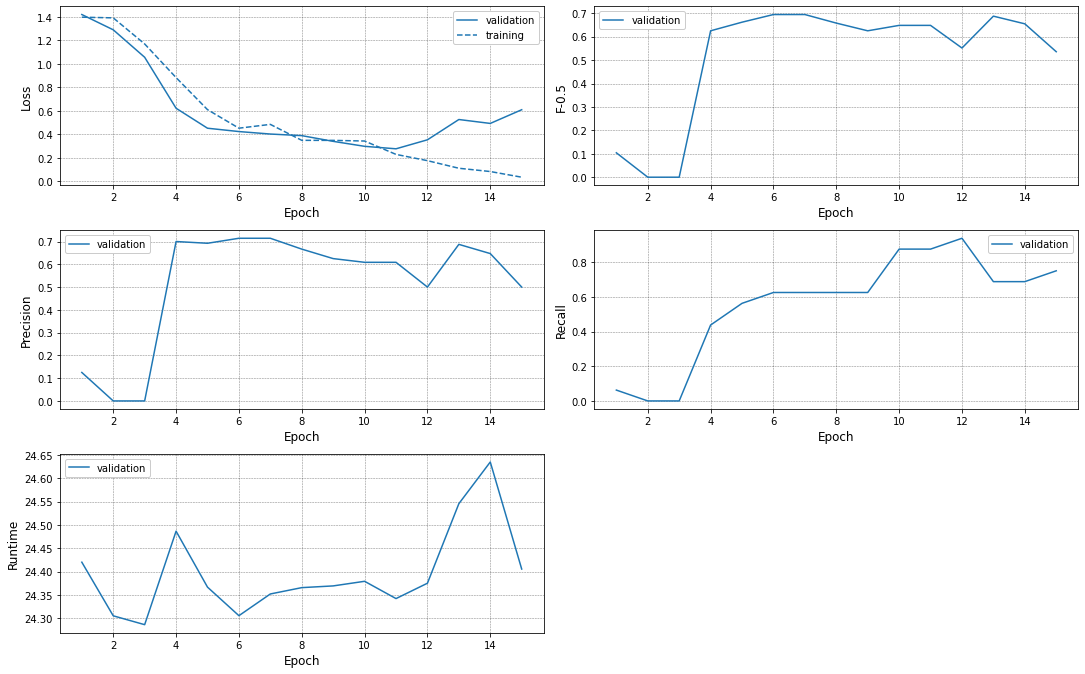

In [42]:
plt.figure(figsize=(15,9))

metrics = ['eval_loss','eval_F-0.5','eval_precision','eval_recall','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        plt.tight_layout()
        ax = plt.subplot(3,2,idx+1).plot(customer_service_history['epoch'],
                                         customer_service_history[metric],
                                         label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(3,2,idx+1).plot(customer_service_history['epoch'],
                                             customer_service_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace('eval_','').capitalize(),fontsize=12)
        plt.legend()

#### • Load the best checkpoint

The best model on our metrics of interest: F-0.5 and precision appears to be the model from epoch 6 (**checkpoint-60**). However, I select checkpoint-140 because the training loss is much lower (it did not underfit as was the case with checkpoint-60).

In [24]:
#Load the model
customer_service_model = AutoModelForSequenceClassification.from_pretrained("../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-140")

customer_service_pred_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

customer_service_predictor = Trainer(
    model             = customer_service_model,
    args              = customer_service_pred_args,
    compute_metrics   = compute_metrics,
)


loading configuration file ../models/absa-aspect-extraction/ensemble_model/customer_service_classifier/checkpoint-140/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

loading weights file ../models/absa-aspect-extraction/ensemble_model/customer_serv

#### • Evaluating the model: How well does it classify tweets?

**Training set**

In [135]:
customer_service_train = customer_service_predictor.predict(cs_train_dataset, metric_key_prefix= 'train')
pd.DataFrame([customer_service_train[-1]])

***** Running Prediction *****
  Num examples = 292
  Batch size = 8


,train_loss,train_precision,train_recall,train_F-0.5,train_runtime,train_samples_per_second,train_steps_per_second
0,0.039082,0.916667,1.0,0.932203,75.1755,3.884,0.492


**Validation set**

In [136]:
customer_service_validation = customer_service_predictor.predict(cs_val_dataset, metric_key_prefix= 'val')
pd.DataFrame([customer_service_validation[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,val_loss,val_precision,val_recall,val_F-0.5,val_runtime,val_samples_per_second,val_steps_per_second
0,0.322017,0.647059,0.6875,0.654762,33.2527,2.947,0.391


Does better on the validation set.

In [137]:
get_summary_report('customer service',val_df['customer service'],customer_service_validation)

- There were 16 customer service cases
- The model made 17 predictions
- 11 were accurate


Does a pretty poor job with recalling the aspect. From the recall, it's clearly overpredicting no speed aspect

**Test set**

In [138]:
customer_service_test = customer_service_predictor.predict(cs_test_dataset, metric_key_prefix= 'test')
pd.DataFrame([customer_service_test[-1]])

***** Running Prediction *****
  Num examples = 98
  Batch size = 8


,test_loss,test_precision,test_recall,test_F-0.5,test_runtime,test_samples_per_second,test_steps_per_second
0,0.1836,0.714286,0.555556,0.675676,26.8313,3.652,0.485


In [139]:
get_summary_report('customer service',test_df['customer service'],customer_service_test)

- There were 9 customer service cases
- The model made 7 predictions
- 5 were accurate


Does okay. Better than chance atleast

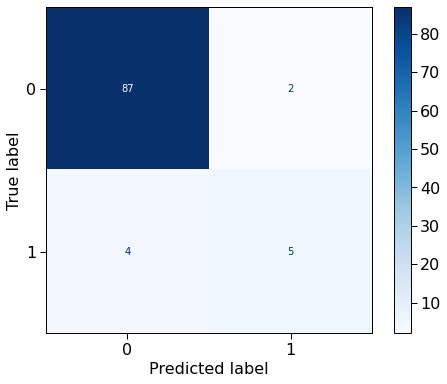

In [141]:
#Generate the confusion matrix
customer_service_test_true = test_df['customer service'].tolist()
customer_service_test_preds = np.argmax(customer_service_test[0], axis=1).flatten()
cs_cm = confusion_matrix(customer_service_test_true, customer_service_test_preds)
cs_disp = ConfusionMatrixDisplay(confusion_matrix=cs_cm)

#Plot the confusion matrix
with plt.style.context(['notebook','no-latex']):
    cs_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### • View misclassified tweets

In [142]:
cs_test_df = test_df[['Text','customer service']]
cs_test_df['model_preds'] = customer_service_test_preds 
cs_misclassified = cs_test_df[cs_test_df['customer service'] != cs_test_df.model_preds]

with pd.option_context('display.max_colwidth', None):
  display(cs_misclassified)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,customer service,model_preds
83,"spectranet_ng hello..pls fix your network service on amusan street, puposola road, new oko-oba..it is terrible and frustrating..poor network since yesterday. i have complained repeatedly but your network in this area is always really bad",1,0
88,damolaonline wifisupport1 tizeti it's really emabarrasing that the service rendered is so poor,0,1
287,"spectranet_ng globacomnigeria i have sent you something on the frustrating experience through your seflcare portal after several complaints and a visit to your bode thomas office. pls fix it today and forever...otherwise, i port",1,0
110,i don't know why spectranet_ng has the shittiest customer service like it's just wild,1,0
123,iamchrisani wifisupport1 boycottfrauds tizeti i hate their generic response 😡😡😡,0,1
186,just had an awesome customer service experience from spectranet_ng . david listened and found a way to make it work. his supervisor tunji (i think) was ace! this is why i stick with spectranet! keep up the great work and don't make me regret my words please!,1,0


Again still missing cases that use the exact words corresponding to the aspect!

---

## 8. Modeling - Full ABSA
**`Aspect extraction`| `Aspect sentiment prediction`**

### a. Load the packages and libraries

In [14]:
#Load metrics for ABSA
from absa_metrics import binary_precision_recall_fscore, aspect_sentiment_accuracy

#Import package for aspect sentiment prediction
import aspect_based_sentiment_analysis as absa

#Load the ABSA sentiment model
nlp = absa.load()

2021-12-06 19:13:09.060703: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized fr

### b. Define function to run full ABSA 

In [18]:
def full_absa_prediction(df, col_name):
    
    """
    Function to perform ABSA on tweets. This is a two-part task of aspect extraction 
    and aspect sentiment prediction
    
    Inputs:
        - df (pd DataFrame): A pandas dataframe to perform annotation on
        - col_name (str): The specific column in the dataframe containing the tweets run absa on
        
    Output:
        - absa_df (pd DataFrame): DataFrame containing the tweets and the ABSA results
    
    """
    
    #List to store detected aspects and their sentiments
    df_list = []
    
    #List containing the binary classifiers
    binary_classifiers = [('reliability',reliability_model),
                          ('price',price_model),
                          ('speed',speed_model),
                          ('coverage',coverage_model),
                          ('customer service', customer_service_model)]
    
    #Iterate through all the tweets
    for tweet in df[col_name]:
        
        #List to store the aspects detected
        aspects_detected = []
        
        #List to store the sentiment values (Positive, Negative or Neutral) for the aspects
        detected_sentiments = []
        
        #Encode the tweet
        encoding = TOKENIZER.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=TOKENIZER.model_max_length,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        #Iterate through each of the binary classifiers
        for aspect,classifier in binary_classifiers:
            
            #Run each binary classifier on the tweet
            aspect_prediction = classifier(encoding["input_ids"], encoding["attention_mask"])
            aspect_prediction = np.argmax(aspect_prediction[0].flatten().detach().numpy())
            
            #If the aspect was predicted to be 1, record the aspect as being found in the tweet
            if aspect_prediction == 1:
                aspects_detected.append(aspect)
                
        if aspects_detected:
            #Next, carry out sentiment prediction on the aspects detected
            sentiment = nlp(tweet,aspects = aspects_detected)
            
            #Iterate through each aspect sentiment predicted results
            for senti_result in sentiment.examples:

                #Get the sentiment scores
                scores = np.array(senti_result.scores)

                #Find the max sentiment score (i.e. the predicted sentiment value)
                max_score = np.argmax(scores)

                #Record the sentiment (string) category for the aspect
                if max_score == 2:

                    detected_sentiments.append("Positive")

                elif max_score == 1:

                    detected_sentiments.append("Negative")

                else:

                    detected_sentiments.append("Neutral")


            #Add the detected aspects and sentiments from the sentence to the list
            df_list.append([tweet,aspects_detected,detected_sentiments])
            
        else:
            df_list.append([tweet,None,None])
        

    absa_df = pd.DataFrame(df_list, 
                       columns=[col_name,'Detected aspects','Predicted sentiment'])
    
    return absa_df

### c. Run ABSA on the validation set

In [19]:
#Quick preview of the validation set
val_df.head()

,Text,price,speed,reliability,coverage,customer service,Sentiment
338,officialkome_ spectranet_ng this people don fr...,0,0,0,0,0,[None]
329,ayomikun_o_ yoruba_dev spectranet_ng i'm.yet t...,0,0,0,0,0,[None]
215,spectranet !!!!! 🤬🤬🤬🤬🤬🤬,0,0,0,0,0,[None]
93,"after buying data see airtel telling me ""now t...",0,0,0,0,0,[None]
169,spectranet ooooo,0,0,0,0,0,[None]


In [21]:
#Run the ABSA model
val_absa_results = full_absa_prediction(val_df, 'Text')

In [52]:
with pd.option_context('display.max_colwidth', None):
    display(val_absa_results)

,Text,Detected aspects,Predicted sentiment
0,officialkome_ spectranet_ng this people don frustrate me finish kai. i'm tired,None,None
1,ayomikun_o_ yoruba_dev spectranet_ng i'm.yet to turn on mine today if i do i'd join in defs,None,None
2,spectranet !!!!! 🤬🤬🤬🤬🤬🤬,None,None
3,"after buying data see airtel telling me ""now that i have data, i should watch one tin one tin. are you people actually ok? it's kukuma not your fault, it's that crippled tizeti i blame.",[speed],[Negative]
4,spectranet ooooo,None,None
...,...,...,...
93,nothing as frustrating as terrible network and spectranet is taking the piss right now,[reliability],[Negative]
94,"kusssman the_only_ayo mtnng glo__nig 9mobileng ntelng airtelnigeria spectranet_ng don't mind then,they just like to make life hard .......useless network provider",None,None
95,tizeti tizeti is not a good isp i've been experiencing this for almost 48 hours and it still continues,[reliability],[Negative]
96,shame on you spectranet,None,None


In [26]:
#Save the ABSA predictions
val_absa_results.to_csv("../model_predictions/binary_relevance_absa_val_preds.csv", index=False)

In [6]:
#If loading the results
val_absa_results = pd.read_csv("../model_predictions/binary_relevance_absa_val_preds.csv")

#Convert from string to list
# val_absa_results['Detected aspects'] = val_absa_results['Detected aspects'].apply(lambda x: eval(x) if isinstance(x,str) else x)
# val_absa_results['Predicted sentiment'] = val_absa_results['Predicted sentiment'].apply(lambda x: eval(x) if isinstance(x,str) else x)

### d. Prepare the data for model evaluation

In [7]:
#Get the true results for the tweets the model predicted on
val_true = merged_absa_df[merged_absa_df.Text.isin(val_absa_results.Text)].reset_index()

#Append the true values to the dataframe
val_true_vs_preds = pd.merge(val_absa_results, val_true, on = 'Text').drop(columns='index')

#Fill NAs and Nones with [None]
val_true_vs_preds = val_true_vs_preds.apply(lambda s: s.fillna({i: [None] for i in val_true_vs_preds.index}))

#Convert from string to list
# val_true_vs_preds.Aspects = val_true_vs_preds.Aspects.apply(lambda x: eval(x) if isinstance(x,str) else x)
# val_true_vs_preds.Sentiment = val_true_vs_preds.Sentiment.apply(lambda x: eval(x) if isinstance(x,str) else x)

#Quick preview
val_true_vs_preds.head()

,Text,Detected aspects,Predicted sentiment,Aspects,Sentiment
0,officialkome_ spectranet_ng this people don fr...,[None],[None],[None],[None]
1,ayomikun_o_ yoruba_dev spectranet_ng i'm.yet t...,[None],[None],[None],[None]
2,spectranet !!!!! 🤬🤬🤬🤬🤬🤬,[None],[None],[None],[None]
3,"after buying data see airtel telling me ""now t...",['speed'],['Negative'],[None],[None]
4,spectranet ooooo,[None],[None],[None],[None]


### e. Model Evaluation [Aspect Extraction]

In [89]:
#Calculate precision, recall and f-0.5
class_metrics, precision, recall, fscore = binary_precision_recall_fscore(
    val_true_vs_preds['Aspects'],
    val_true_vs_preds['Detected aspects'], 
    beta = 0.5)

print(f"Precision: {precision:.3f}  Recall: {recall:.3f} F-0.5: {fscore:.3f}")

Precision: 0.565  Recall: 0.426 F-0.5: 0.531


In [83]:
(pd.DataFrame(class_metrics).T).iloc[:,-3:]

,Precision,Recall,F-0.5
price,0.333333,0.333333,0.333333
speed,0.400000,0.153846,0.303030
reliability,0.800000,0.363636,0.645161
coverage,0.714286,0.555556,0.675676
customer service,0.647059,0.687500,0.654762


### e. Model Evaluation [Aspect Sentiment Prediction]

In [49]:
aspect_accuracies,micro_accuracy,macro_accuracy=aspect_sentiment_accuracy(val_true_vs_preds['Aspects'],
                                                                          val_true_vs_preds['Detected aspects'],
                                                                          val_true_vs_preds['Sentiment'],
                                                                          val_true_vs_preds['Predicted sentiment'])

print(f"Micro accuracy:{micro_accuracy:.3f}   Macro accuracy:{macro_accuracy:.3f}")

Micro accuracy:0.846   Macro accuracy:0.782


In [45]:
(pd.DataFrame([aspect_accuracies]).T).rename(columns={0:'Accuracy'})

,Accuracy
price,0.500000
speed,0.500000
reliability,1.000000
coverage,1.000000
customer service,0.909091


---

### Validation set for evaluation

In [75]:
eval_val_df = pd.concat([val_df.reset_index().drop(columns='index').iloc[:,:-1],val_true_vs_preds[['Aspects','Sentiment']]],axis=1)

In [76]:
eval_val_df.head()

,Text,price,speed,reliability,coverage,customer service,Aspects,Sentiment
0,officialkome_ spectranet_ng this people don fr...,0,0,0,0,0,[None],[None]
1,ayomikun_o_ yoruba_dev spectranet_ng i'm.yet t...,0,0,0,0,0,[None],[None]
2,spectranet !!!!! 🤬🤬🤬🤬🤬🤬,0,0,0,0,0,[None],[None]
3,"after buying data see airtel telling me ""now t...",0,0,0,0,0,[None],[None]
4,spectranet ooooo,0,0,0,0,0,[None],[None]


In [77]:
eval_val_df.to_csv("../data/model-evaluation/validation_dataset.csv",index=False)

### Test set for evaluation

In [80]:
#Get the test set with original annotation
test_true = merged_absa_df[merged_absa_df.Text.isin(test_df.Text)].reset_index()

#Append the original annotations to the binarized test set
test_true_binarized_with_original  = pd.merge(test_df.reset_index().drop(columns='index').iloc[:,:-1], 
                                              test_true,
                                              on = 'Text').drop(columns='index')

#Fill NAs and Nones with [None]
test_true_binarized_with_original = test_true_binarized_with_original.apply(lambda s: s.fillna({i: [None] for i in test_true_binarized_with_original.index}))

test_true_binarized_with_original

,Text,price,speed,reliability,coverage,customer service,Aspects,Sentiment
0,deejay_klem smilecomsng well this means i will...,0,0,0,0,0,[None],[None]
1,myaccessbank hello please i can't seem to find...,0,0,0,0,0,[None],[None]
2,spectranet_ng hello please can i add multiple ...,0,0,0,0,0,[None],[None]
3,spectranet is shit,0,0,0,0,0,[None],[None]
4,"tizeti is a special brand of useless, when it ...",0,1,0,0,0,[speed],[Negative]
...,...,...,...,...,...,...,...,...
93,spectranet_ng pls are you ppl still doing prom...,0,0,0,0,0,[None],[None]
94,spectranet_ng is today double data please 😊,0,0,0,0,0,[None],[None]
95,this game dey hungry me tonight but spectranet...,0,0,0,0,0,[None],[None]
96,wifisupport1 tizeti after making me pay 12500 ...,1,0,0,0,0,[price],[Negative]


In [82]:
test_true_binarized_with_original.to_csv("../data/model-evaluation/test_dataset.csv",index=False)